In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [164]:
import numpy as np
import pylab as plt

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from grid import regridXYZ
from utils.utils import midPoint, gridLimits
from parabolas import fitLeicaData, loadLeicaData
from plotting import surface3dPlot, surfacePlot, barChartPlot

In [ ]:
def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg

def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [104]:
n = 512
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
ref_scans = ['2020_03_16_02:21:06',
             '2020_03_16_02:54:59',
             '2020_03_16_03:19:50',
             '2020_03_16_03:44:25',
             '2020_03_16_04:09:06',
             '2020_03_16_04:33:33',
             '2020_03_16_04:58:03',
             '2020_03_16_05:22:24',
             '2020_03_16_05:47:09',
             '2020_03_16_06:11:20',
             '2020_03_16_06:35:42',
             '2020_03_16_07:00:20',
             '2020_03_16_07:24:39',
             '2020_03_16_07:48:47',
             '2020_03_16_08:12:50',
             '2020_03_16_08:37:03',
             '2020_03_16_09:01:35',
            ]

In [162]:
%%time

xMaxArr = np.zeros(len(ref_scans), dtype=np.float)
xMinArr = np.zeros(len(ref_scans), dtype=np.float)
yMaxArr = np.zeros(len(ref_scans), dtype=np.float)
yMinArr = np.zeros(len(ref_scans), dtype=np.float)

for i,rs in enumerate(ref_scans):
    
    filename = "{}/{}.ptx.csv".format(scanDir, rs)
    
    orgData, cleanData = loadLeicaData(filename, n=n, numpy=False)

    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xg, yg, zg = regridXYZ(x, y, z, n=n)

    md = maskXYZ(xg, yg, zg, n=n, guess=guess, radialMask=False)
    
    xr, yr, zr = md['rotated']
    cr = md['parabolaFitCoeffs']
    
    xr -= cr[1]
    yr -= cr[2]
    
    xMaxArr[i] = np.nanmax(xr)
    xMinArr[i] = np.nanmin(xr)
    yMaxArr[i] = np.nanmax(yr)
    yMinArr[i] = np.nanmin(yr)

CPU times: user 17min 31s, sys: 14min 53s, total: 32min 25s
Wall time: 2min 30s


<IPython.core.display.Javascript object>


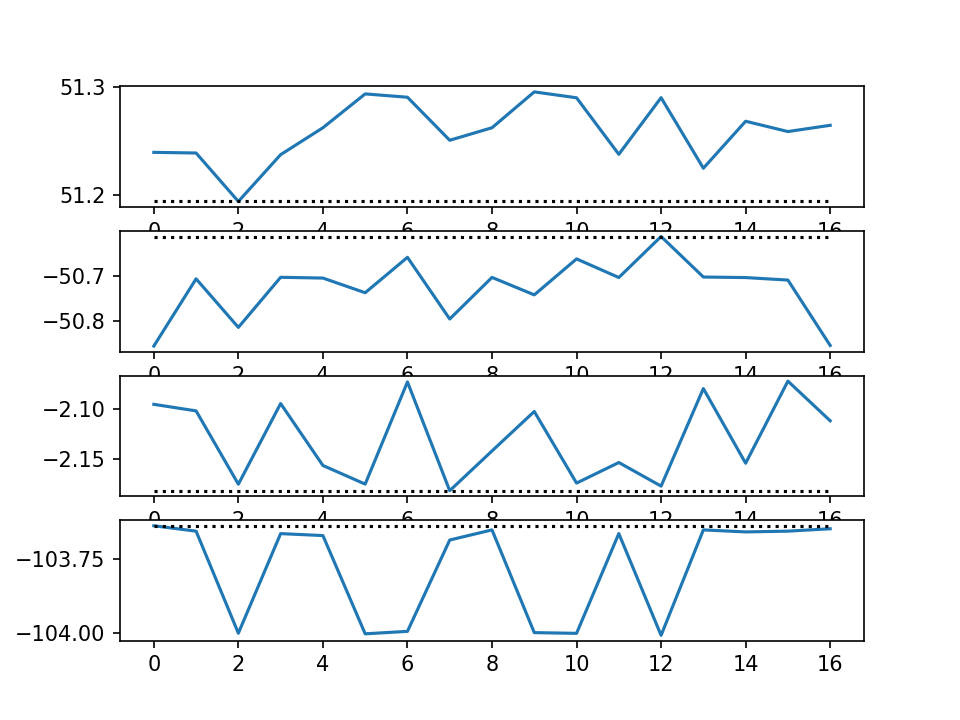

In [165]:
xMax = np.nanmin(xMaxArr)
xMin = np.nanmax(xMinArr)
yMax = np.nanmin(yMaxArr)
yMin = np.nanmax(yMinArr)

plt.figure(dpi=150)

plt.subplot(411)
plt.plot(xMaxArr)
plt.plot([xMax]*len(xMaxArr), 'k:')

plt.subplot(412)
plt.plot(xMinArr)
plt.plot([xMin]*len(xMinArr), 'k:')

plt.subplot(413)
plt.plot(yMaxArr)
plt.plot([yMax]*len(yMaxArr), 'k:')

plt.subplot(414)
plt.plot(yMinArr)
plt.plot([yMin]*len(yMinArr), 'k:')

In [189]:
%%time

rmsArr = np.zeros(len(ref_scans), dtype=np.float)
crArr = np.zeros((len(ref_scans),6), dtype=np.float)
refScanArr = np.zeros((len(ref_scans),3,n,n), dtype=np.float)

for i,rs in enumerate(ref_scans):

    filename = "{}/{}.ptx.csv".format(scanDir, rs)

    orgData, cleanData = loadLeicaData(filename, n=n, numpy=False)

    x = orgData[0]
    y = orgData[1]
    z = orgData[2]

    xg, yg, zg = regridXYZ(x, y, z, n=n)

    md = maskXYZ(xg, yg, zg, n=n, guess=guess, radialMask=False)
    xr, yr, zr = md['rotated']
    cr = md['parabolaFitCoeffs']

    xr -= cr[1]
    yr -= cr[2]
    #zr -= cr[3]

    xg, yg, zg = regridXYZ(xr, yr, zr, n=n, xmax=xMax, xmin=xMin, ymax=yMax, ymin=yMin)

    crArr[i] = cr
    refScanArr[i] = xg, yg, zg
    rmsArr[i] = md['fitResidual'].std()

CPU times: user 22min 27s, sys: 15min 36s, total: 38min 3s
Wall time: 6min 54s


<IPython.core.display.Javascript object>


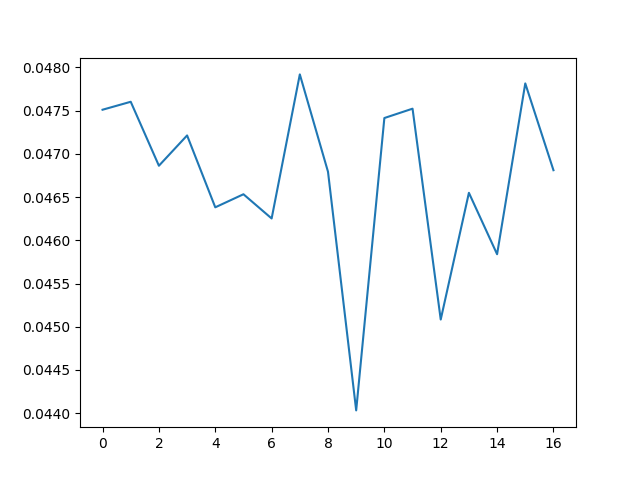

<IPython.core.display.Javascript object>


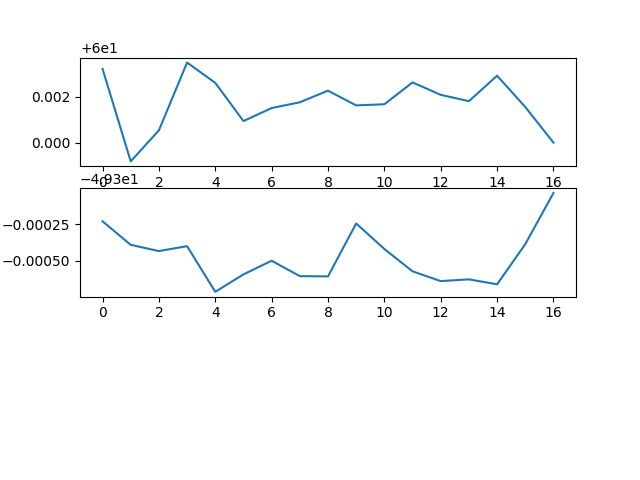

In [174]:
plt.figure()
plt.plot(rmsArr[:])

plt.figure()
plt.subplot(311)
plt.plot(crArr[:,0])
plt.subplot(312)
plt.plot(crArr[:,3])

In [195]:
#avgRefScan = refScanArr.mean(axis=0)
avgRefScan = np.ma.average(refScanArr, axis=0, weights=np.power(rmsArr, -2))
avgRefScan = np.ma.masked_invalid(avgRefScan)
#avgRefScan[2] = np.ma.masked_less(avgRefScan[2], 0)
avgRefScan[0] = np.ma.masked_where(avgRefScan[2].mask, avgRefScan[0])
avgRefScan[1] = np.ma.masked_where(avgRefScan[2].mask, avgRefScan[1])

<IPython.core.display.Javascript object>


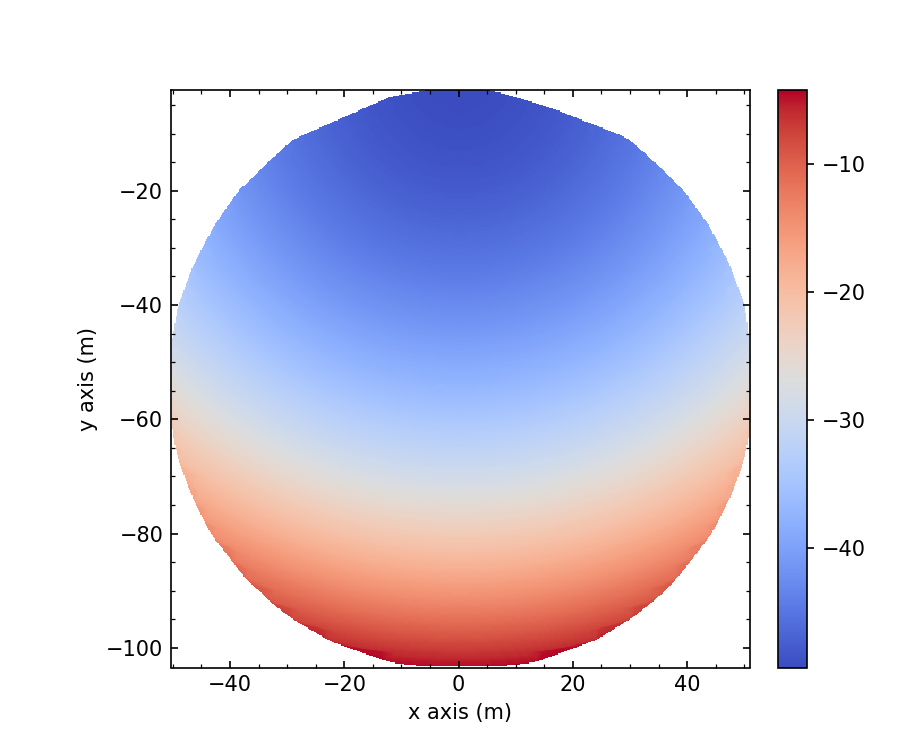

In [197]:
vmin = np.nanmin(avgRefScan[2])
vmax = np.nanmax(avgRefScan[2])
surfacePlot(avgRefScan[0], avgRefScan[1], avgRefScan[2].T, 
            vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)/2)